<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

import itertools

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, consensus_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
def class_bar(data, sign):
    df = data.copy()
    df_row = (df[sign].value_counts(normalize=True)*100).reset_index()
    
    plt.gcf().set_size_inches(16,5)
    plt.rcParams.update({'font.size':11})
    sns.barplot(x='index', y=sign, data=df_row, edgecolor='.1', saturation=1)
    for index, row_text in df_row.iterrows():
        plt.text(index, row_text[sign]*1.01, '{}%'.format(round(row_text[sign], 1)), color='black', ha='center')
        
    plt.ylim([0, 120])
    plt.grid(axis='y')
    plt.xlabel('Класс')
    plt.ylabel('Доля класса')
    plt.title('Диаграмма классового баланса')

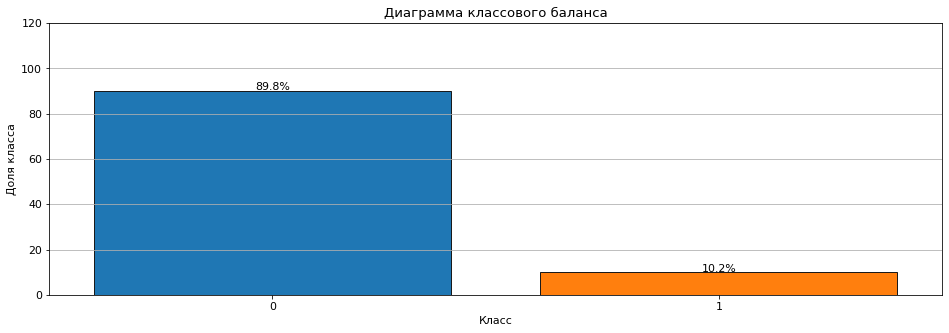

In [7]:
class_bar(data, 'toxic')

Описание данных:

- Количество строк: 159571
- Количество столбцов: 2

Промежуточные выводы:

- наблюдается сильный дисбаланс классов;
- прибегнем к регуляризации и лемматизации;

Далее используем регулярные выражения для очистки данных и токенизации:
    - оставим в комментариях только латинские буквы верхних и нижних регистров;
    - оставим любую цифру, букву или знак подчёркивания последовательностью сравнения один или более раз - <b>\w+</b>;
    - оставим любую цифру, букву или знак подчёркивания где предыдущий символ может быть сопоставлен ноль или более раз, вместо одного сравнения - <b>\w+</b>;
    - оставим в комментариях символ <b>'-\'?</b>.

In [8]:
def regular_tokenizer(data, sign):
    df = data.copy()
    token = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df['token'] = df['text'].str.lower().apply(token.tokenize)
    
    stop_words = set(stopwords.words('english'))
    
    list_token = df['token'].values
    list_row = []
    for i in notebook.tqdm(range(list_token.shape[0])):
        without_stop_words = [word for word in list_token[i] if not word in stop_words]
        list_row.append(without_stop_words)
    df['token'] = list_row
    return df

In [9]:
df = regular_tokenizer(data, 'text')

Визуализируем распределение длины комментариев; 

In [10]:
def chart_distribution(data):
    
    def print_info():
        all_words = [word for token in data for word in token]
        sentence_lengths = [len(token) for token in data]
        VOCAB = sorted(list(set(all_words)))
        print('Всего {} слов с объёмом словаря - {}'.format(len(all_words), len(VOCAB)))
        print('Максимальная длинна поста - {}'.format(max(sentence_lengths)))
        return pd.Series(sentence_lengths)
    
    def chart(df):
        plt.gcf().set_size_inches(16,7)
        plt.rcParams.update({'font.size':11})
        
        plt.axvline(x = df.median(), linewidth=3, color='k', linestyle=':', label=('Медиана - {:.1f}'.format(df.median())))
        plt.axvline(x = df.mean(), linewidth=3, color='k', linestyle='solid', label=('Среднее - {:.1f}'.format(df.mean())))
        plt.axvline(x = df.median() + df.std(), linewidth=3, color='k', linestyle='--', label=('std - {:.1f}'.format(df.median())))
        plt.axvline(x = df.median() - df.std(), linewidth=3, color='k', linestyle='--')
        plt.axvspan((df.mean() - df.std()), (df.mean() + df.std()), linewidth=3, color='g', hatch = '///', alpha = 0.5, linestyle=':')
        
        plt.legend()
        plt.title('Распределение длины комментариев')
        plt.xlabel('Длина комментариев, слов')
        
        df.plot(kind='hist', bins=400, ec='k', alpha=0.8)
        df.plot.kde(xlim = (df.min(), df.max()), linewidth = 2, color = 'r', secondary_y=True)
        
        plt.xlim([0,400])
        plt.grid()
        
    chart(print_info())

Всего 5514500 слов с объёмом словаря - 192358
Максимальная длинна поста - 1250


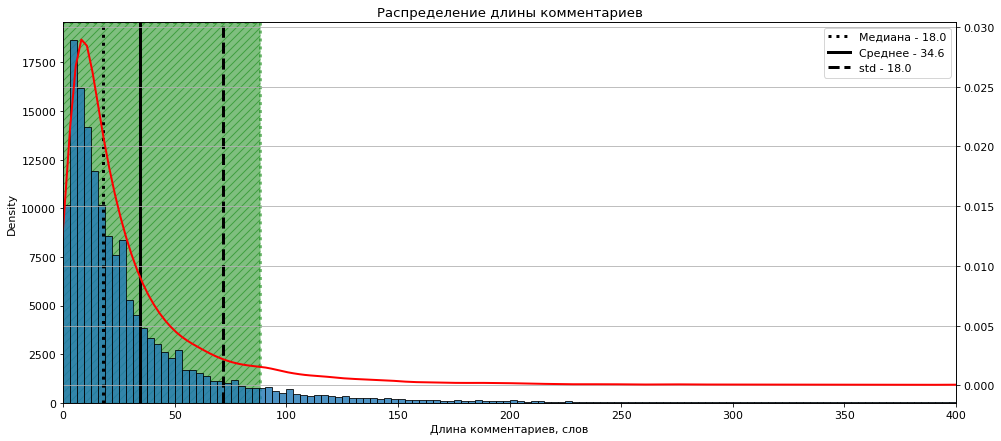

In [11]:
chart_distribution(df['token'])

<b>Промежуточный вывод:</b>
- Всего в нашем датафрейме 5 514 500 слов;
- Количество уникальных слов — 192 358;
- Длина самого большого комментария — 1250 слов;  
- Mean комментария - 35 слов (median — 18 слов);
- Большинство записей имеет длину до примерно ста слов в комментарии.

In [12]:
def lemmatizer(df_row, sign):
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    def lemmatiz(data):
        list_row = []
        list_token = data.values
        lemmatizer = WordNetLemmatizer()
        for i in notebook.tqdm(range(list_token.shape[0])):
            list_row.append(" ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in list_token[i]]))
        return list_row
    df = df_row.copy()
    return lemmatiz(df[sign])

In [13]:
df['lemm_text'] = lemmatizer(df, 'token')

In [14]:
df_clean = df[['lemm_text', 'toxic']].copy()

In [15]:
def creating_variables(df_row, sign_features, sign_target, test_size):
    df = df_row.copy()
    target = df[sign_target]
    features = df[sign_features]
    
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = test_size, random_state = 12345)
    
    return {'data': df,
            'features': features,
            'target': target,
            
            'features_train': features_train,
            'features_test': features_test,
            'target_train': target_train,
            'target_test': target_test,
           
            'corpus': features.tolist(),
            'corpus_target': target.tolist(),
            'corpus_train': features_train.tolist(),
            'corpus_test': features_test.tolist()}

In [16]:
sample = creating_variables(df_clean, 'lemm_text', 'toxic', 0.25)

1.11 Напишем функцию преобразования комментов в векторный формат

Рассмотрим 2 подхода:

- Мешок слов
- TF-IDF

In [17]:
def count_vector(row, metod='count_vector'):
    if metod == 'count_vector':
        count_vectorizer = CountVectorizer()
    if metod == 'tfidf':
        count_vectorizer = TfidfVectorizer()
    emb = count_vectorizer.fit_transform(row)
    return emb, count_vectorizer

1.12 Создадим словать в который запишем преобразованные корпусы:

In [18]:
sample_corpus = {}

In [46]:
sample_corpus['n_gramm_train'], count_vectorizer = count_vector(sample['corpus_train'])
sample_corpus['n_gramm_test'] = count_vectorizer.transform(sample['corpus_test'])

sample_corpus['tfidf_train'], tfidf_vectorizer = count_vector(sample['corpus_train'], 'tfidf')
sample_corpus['tfidf_test'] = tfidf_vectorizer.transform(sample['corpus_test'], 'tfidf')

In [20]:
def plot_LSA(test_data, test_labels, title, xy_lim = False):
        lsa = TruncatedSVD(n_components = 2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['b', 'r']
                
        plt.gcf().set_size_inches(16, 6)
        plt.rcParams.update({'font.size': 11}) 
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s = 4, alpha = .8, c = test_labels, cmap = matplotlib.colors.ListedColormap(colors))
        
        red_patch = mpatches.Patch(color = 'b', label = '0')
        green_patch = mpatches.Patch(color = 'r', label = '1')
        plt.legend(handles=[red_patch, green_patch])
        
        plt.grid()
        plt.title(title)
        
        if xy_lim:
            plt.xlim([-1, 12])
            plt.ylim([-1, 5])
        else:
            plt.gcf().gca().add_artist(plt.Circle((0.17, 0), 0.16, color = 'k', fill = False, linewidth = 4, linestyle = '--'))

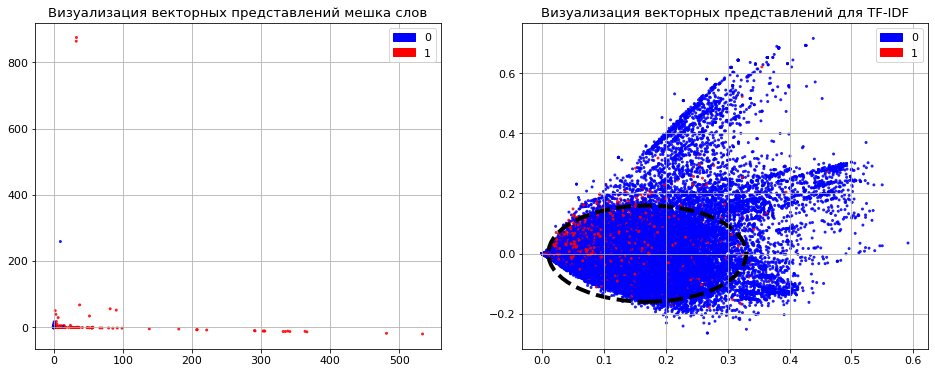

In [21]:
plt.subplot(1, 2, 1)
plot_LSA(sample_corpus['n_gramm_train'], sample['target_train'], 'Визуализация векторных представлений мешка слов')
plt.subplot(1, 2, 2)
plot_LSA(sample_corpus['tfidf_train'], sample['target_train'], 'Визуализация векторных представлений для TF-IDF')

<b>Промежуточный вывод:</b>
- визуальное представление мешка слов показало, что классы не распределены как нужно;
- визуальное представление для TF-IDF показало: классы не имеют чёткого разделения, но можно заметить, что имеется область. В эту область попадает более количество значений классов. Но ещё можно заметить, что за границей области концентрация нерелевантных значений выше. Это похоже на положительный знак.

## Обучение

Далее будем использовать методы:


- <b>Логистическая регрессия;</b>
- <b>Случайный лес;</b>
- <b>Дерево решений.</b>

In [22]:
models_default_n_gramm = {}

models_default_tfidf = {}

In [23]:
models_default_n_gramm['linear'] = LogisticRegression(random_state=12345, n_jobs=-1)
models_default_n_gramm['tree'] = DecisionTreeClassifier(random_state=12345)
models_default_n_gramm['forest'] = RandomForestClassifier(random_state=12345, n_jobs=-1)

models_default_tfidf['linear'] = LogisticRegression(random_state=12345, n_jobs=-1)
models_default_tfidf['tree'] = DecisionTreeClassifier(random_state=12345)
models_default_tfidf['forest'] = RandomForestClassifier(random_state=12345, n_jobs=-1)

In [24]:
def fit_models(models, features, target, title, plot = True):
    def fit():
        dict_time_1 = {}
        for model in models:
            model_row = models[model]
            
            start_time = time.time()
            model_row.fit(features, target)
            end_time = time.time()

            dict_time_1[model] = end_time - start_time
        df_time = pd.DataFrame.from_dict(dict_time_1, orient='index').reset_index().rename(columns={0: 'values', 'index': 'model'})
        return df_time
    
    def chart(df):
        plt.gcf().set_size_inches(16, 5)
        plt.rcParams.update({'font.size': 11})
        
        sns.barplot(x = 'model', y = 'values', data = df, edgecolor='.1', saturation = 1)
        
        for index, row_text in df.iterrows():
            plt.text(index, row_text['values'] * 1.01, round(row_text['values'], 1), color = 'black', ha = 'center')
        
        plt.grid(axis = 'y')
        plt.xlabel('Модель')
        plt.ylabel('Время обучения, сек.')
        plt.title('Время обучения моделей на корпусе {}'.format(title))
        plt.show()
        
    df_time = fit()
    if plot:
        chart(df_time)
    
    return df_time

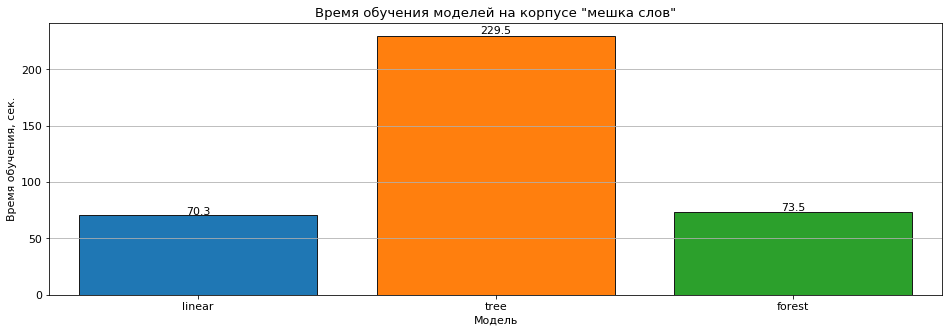

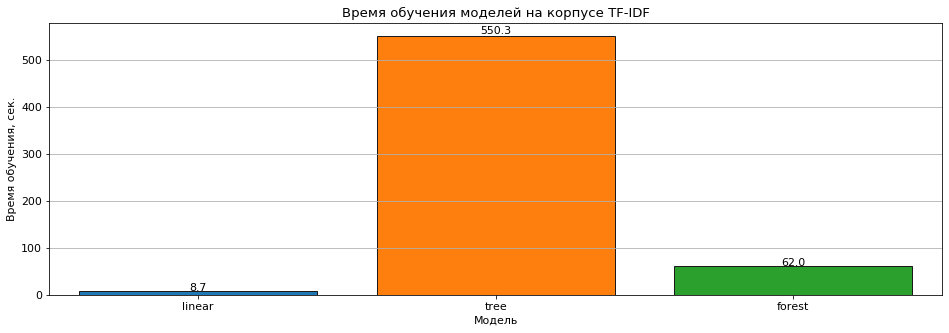

In [25]:
time_fit_default_n_gramm = fit_models(models_default_n_gramm, sample_corpus['n_gramm_train'], sample['target_train'], '"мешка слов"')
time_fit_default_tfidf = fit_models(models_default_tfidf, sample_corpus['tfidf_train'], sample['target_train'], 'TF-IDF')


<b>Промежуточный итог:</b>
- Обучение DecisionTree model занимает самое большое количество времени;
- Самым быстрым в обучении оказался алгоритм LogisticRegression;

In [26]:
def score_metrics(models, sample, corpus, metod):
    dict_1 = {}
    for model in models:
        model_row = models[model]
            
        dict_2 = {'train': [], 'test': []}
        for row in ['train', 'test']:
            features = corpus[metod + '_' + row]
            target = sample['target_' + row]
            
            start_time = time.time()
            pred = model_row.predict(features)
            pred_proba = model_row.predict_proba(features)[:, 1]
            end_time = time.time()
                 
            dict_2[row].append(accuracy_score(target, pred))
            dict_2[row].append(recall_score(target, pred))
            dict_2[row].append(precision_score(target, pred))
            dict_2[row].append(f1_score(target, pred))
            dict_2[row].append(roc_auc_score(target, pred_proba))
            fpr, tpr, thresholds = roc_curve(target, pred_proba, pos_label = 1)
            dict_2[row].append(fpr)
            dict_2[row].append(tpr)
            dict_2[row].append(thresholds)
            dict_2[row].append(confusion_matrix(target, pred))
            dict_2[row].append(end_time - start_time)
            
                           
        dict_1[model] = pd.DataFrame.from_dict(dict_2).reset_index().rename(columns={0: 'train', 1: 'test', 'index': 'metrics'})
        dict_1[model]['metrics'] = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc', 'fpr', 'tpr', 'thresholds', 'cm', 'prediction_time']
    
    return dict_1

In [27]:
metrics_default_n_gramm = score_metrics(models_default_n_gramm, sample, sample_corpus, 'n_gramm')
metrics_default_tfidf = score_metrics(models_default_tfidf, sample, sample_corpus, 'tfidf')

In [28]:
def bar_metrics(metrics, list_metrics):
    
    def df_concat(metric):
        list_1 = []
        list_2 = []
        list_3 = []
        for row in ['train', 'test']:
            for model in metrics:
                df = metrics[model]
                list_1.append(model)
                list_2.append(df[df['metrics'] == metric][row].values[0])
                list_3.append(row)
        df_row = pd.DataFrame({'model': list_1, 'values': list_2, 'version': list_3})
        index = [i for i in range(int(len(list_3)/2))]
        df_row.index = index + index
        return df_row
    
    def confusion_matrix():
        
        plt.gcf().set_size_inches(16, 5)
        plt.rcParams.update({'font.size': 11})
        for model, p in zip(metrics, range(3)):
            plt.subplot(1, 3, p+1)
            cm = metrics[model].query('metrics == "cm"')['test'].values[0]
            classes = ['0','1']
            plt.imshow(cm)
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes)
            plt.yticks(tick_marks, classes)

            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = 'center', color = 'white' if cm[i, j] < thresh else 'black', fontsize = 15)

            plt.title('Матрица ошбок модели — {}'.format(model))
            plt.ylabel('Ответы')
            plt.xlabel('Предсказания')
        plt.show()
    
    def chart():
        dict_name_metrics = {'prediction_time': 'Время затраченное на предсказание', 'accuracy': 'Доля правильных ответов (accuracy)', 'recall': 'Полнота (recall)', 'precision': 'Точность (precision)', 'f1': 'Cреднее гармоническое полноты и точности (F1)', 'roc_auc': 'Площадь под кривой ошибок (ROC AUC)'}
        nrows = math.ceil(len(list_metrics)/2)
        plt.gcf().set_size_inches(16, 5.5 * nrows)
        plt.rcParams.update({'font.size': 11})
        plt.subplots_adjust(hspace=0.3)
        for metric, p in zip(list_metrics, range(len(list_metrics))):
            plt.subplot(nrows, 2, p+1)
            df = df_concat(metric)
            sns.barplot(x = 'model', y = 'values', hue = 'version', data = df, edgecolor='.1', saturation = 1)            

            for index, row_text in df.iterrows():
                ha = 'right' if row_text['version'] == 'train' else 'left'
                plt.text(index, row_text['values'] * 1.01, round(row_text['values'], 3), color = 'black', ha = ha)
                    
            plt.legend(title = False)
            plt.grid(axis = 'y')
            plt.xlabel('Модель')
            plt.ylabel('{}'.format('Значение метрики' if metric != 'prediction_time' else 'Время предсказания, сек'))
            plt.title('{}'.format(dict_name_metrics[metric]))
            plt.ylim([0, df.max()[1] * 1.3])
        plt.show()
    
    def AUC_ROC_curve(): 
        plt.gcf().set_size_inches(16, 5)
        plt.rcParams.update({'font.size': 11})
        plt.plot([0, 1], [0, 1], color = 'k', linestyle='dashdot', lw = 3)
        for model in metrics:
            
            fpr = metrics[model].query('metrics == "fpr"')['test'].values[0]
            tpr = metrics[model].query('metrics == "tpr"')['test'].values[0]
            plt.plot(fpr, tpr, lw = 2, label = model)
            
        plt.grid()
        plt.legend()
        plt.title('Кривая ошибок (ROC) на тестовой выборке')
        plt.xlabel('Доля ложноположительных ответов (FPR)')
        plt.ylabel('Доля истинно положительных ответов (TPR)')
        plt.show()
    
    confusion_matrix()
    if list_metrics != []:
        chart()
    AUC_ROC_curve()

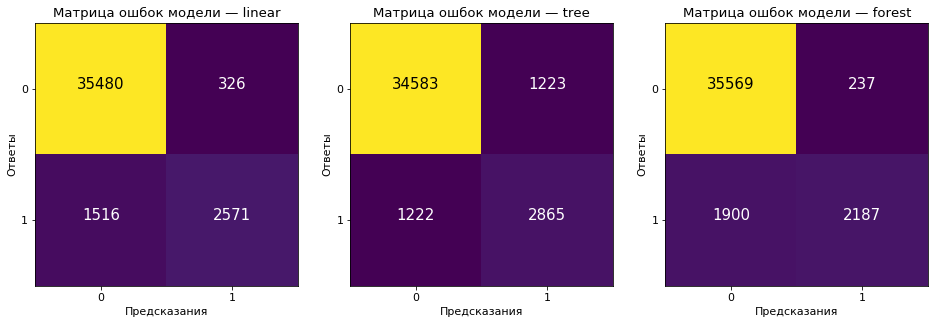

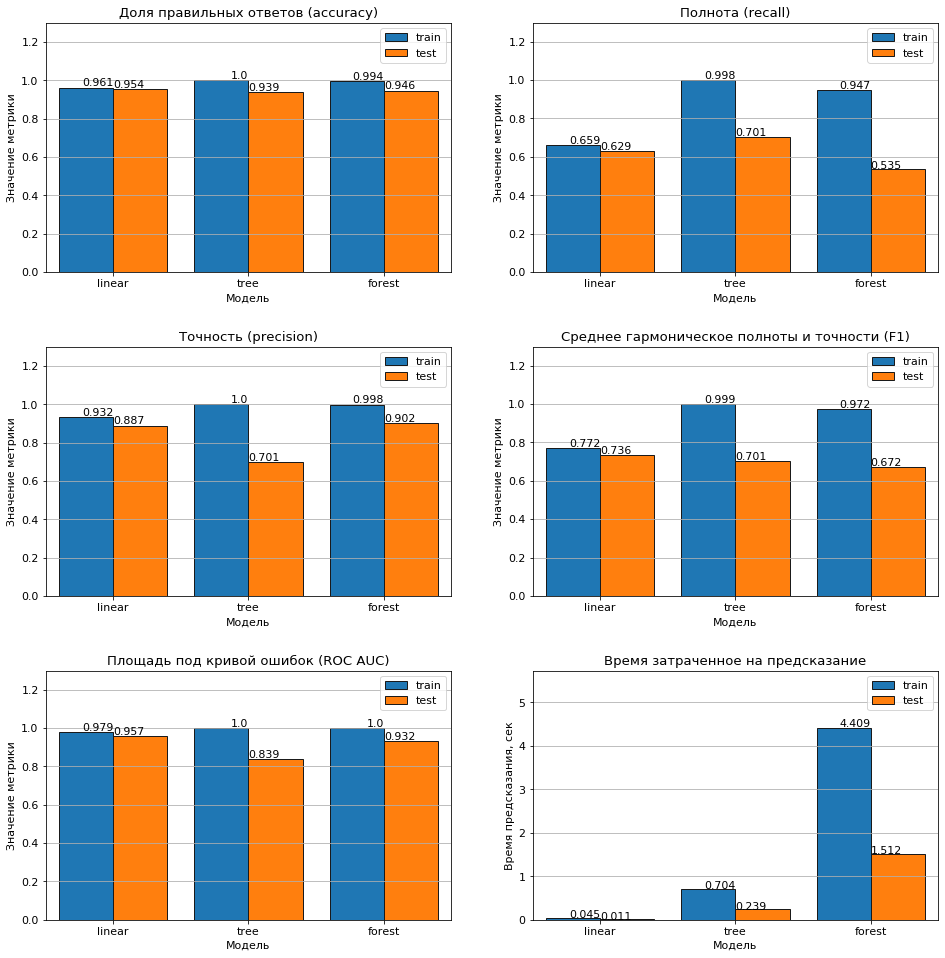

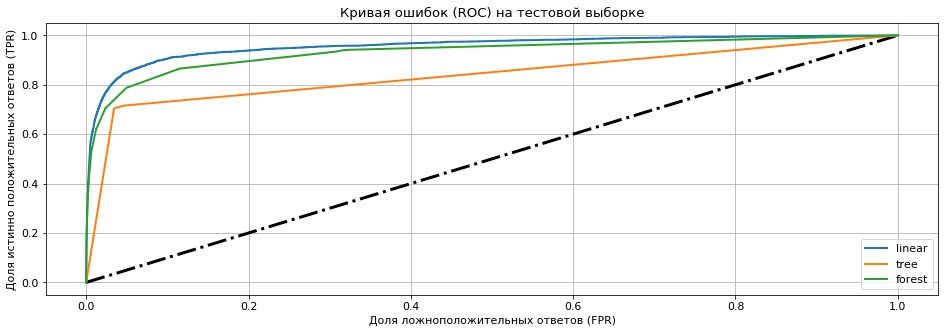

In [29]:
bar_metrics(metrics_default_n_gramm, ['accuracy', 'recall', 'precision', 'f1', 'roc_auc', 'prediction_time'])


<b>Промежуточные итоги:</b>
- Хуже всех определяется 1 класс(дерево), но в то же время модель определила больше всего 1 класс;
- RandomForest всё таки уступает логистической регресси, но лучше Decision Tree;
- Логичстиеческая регрессия показывает себя лучше всего, так как лучше всего предсказывает и тратит на это меньше всего времени, имея самую высокую точность.

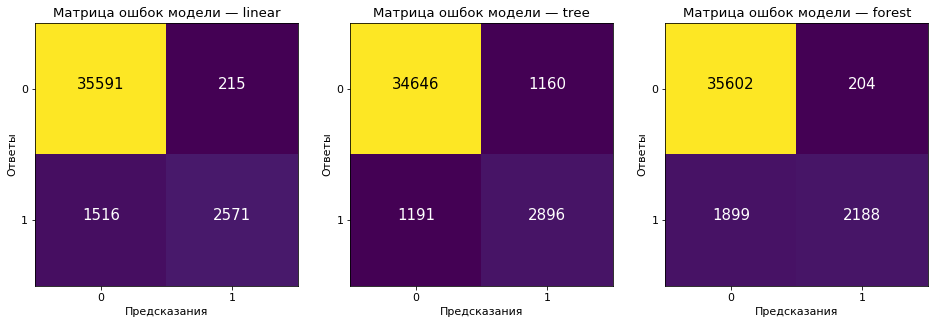

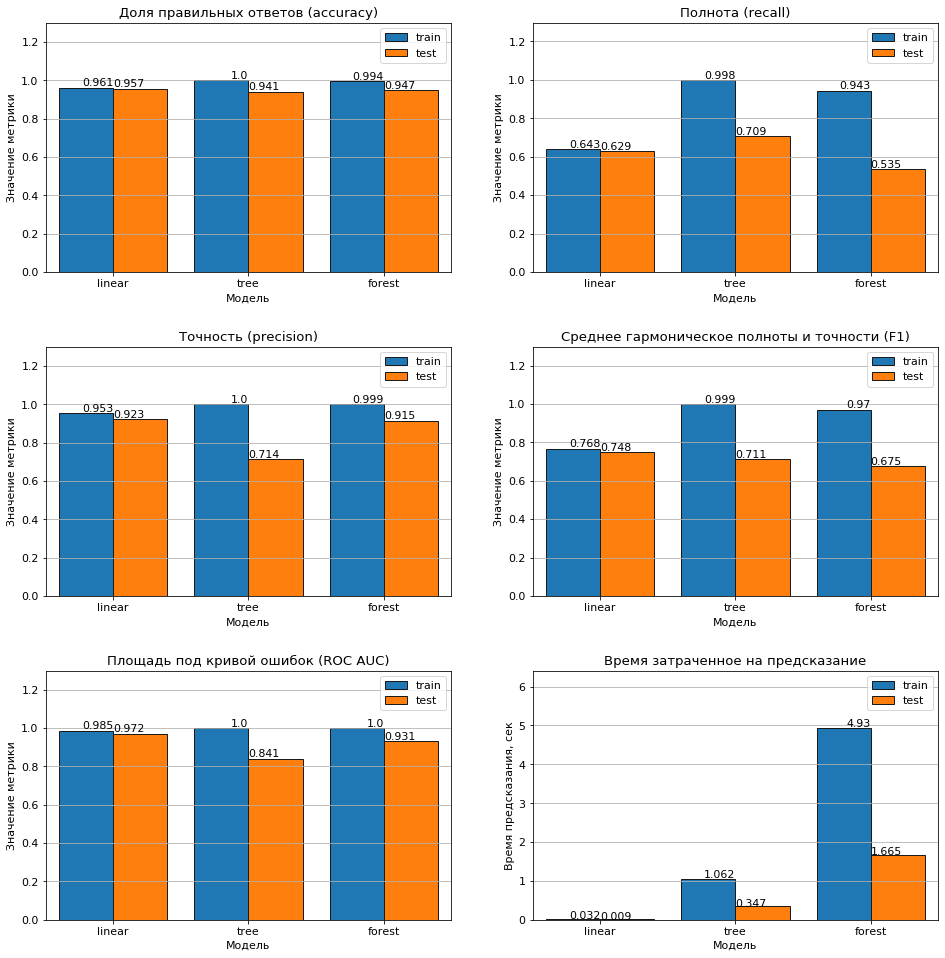

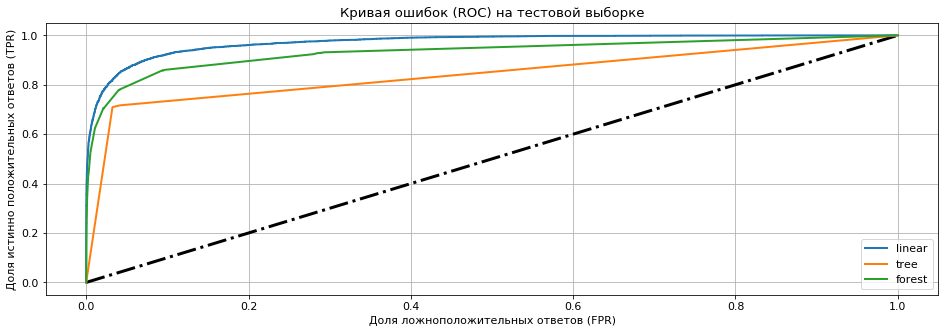

In [30]:
bar_metrics(metrics_default_tfidf, ['accuracy', 'recall', 'precision', 'f1', 'roc_auc', 'prediction_time'])


<b>Ситуация на TF-IDF выглядит аналогично, как и с мешком слов. Но можно заметить, что на TF-IDF метрики лучше, поэтом в дальнейшем будем использовать лишь этот метод.</b>

Далее будем бороться с дисбалансом классов, используя upsampling, и "играясь" с порогом классификации.

In [31]:
def sampled(df, corpus, repeat, metod = 'count_vector'):
    random_state = 42
    sample_list = {}
    
    features = df['features_train']
    target = df['target_train']
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = random_state)
    
    if metod == 'count_vector':
        corpus_upsampled, pas = count_vector(features_upsampled.tolist())
        corpus_test = corpus['n_gramm_test']
        row = 'n_gramm'
    else:
        corpus_upsampled, pas = count_vector(features_upsampled.tolist(), 'tfidf')
        corpus_test = corpus['tfidf_test']
        row = 'tfidf'
    
    sample_dict = {row + '_train': corpus_upsampled,
                   'target_train': target_upsampled,
                   row + '_test': corpus_test,
                   'target_test': df['target_test']}
        
    return sample_dict

In [32]:
learning_outcomes = {'Accuracy': [0.956959867645953, 0.9601183164966285, 0.9587145614518838, 0.9551299726769107, 0.9512947133582332, 0.9471586493871105, 0.9434236582859148, 0.9395382648584965, 0.9364800842253027, 0.9340736470057404],
                     'Recall': [0.623059866962306, 0.729490022172949, 0.7861542251786154, 0.8171963537817196, 0.8371520078837152, 0.8531658043853165, 0.8635131805863513, 0.871150529687115, 0.8790342448879034, 0.8879034244887903],
                     'Precision': [0.9311487481590575, 0.8572669368847713, 0.8037783375314862, 0.7599083619702176, 0.726068376068376, 0.6960804020100503, 0.6730030721966206, 0.6517972350230414, 0.635893780074853, 0.6236373074926458],
                     'F1': [0.7465682656826569, 0.7882337282044457, 0.7948686013202142, 0.7875118708452041, 0.7776633482091773, 0.7666592871374808, 0.7564476097982087, 0.7456769295655842, 0.737952430196484, 0.732669241715796],
                     'ROC-AUC': [0.9707942283698107, 0.9724790042579933, 0.9731150432334212, 0.9734220898937743, 0.9735813265194, 0.9736581706869498, 0.9736998825563711, 0.9737111853935771, 0.9737095147187347, 0.9736928767223608]}

In [33]:
def charts_learning_outcomes(list_row):
    colors = ['b', 'g', 'red', 'c', 'purple', 'lightpink', 'lightgrey', 'coral', 'wheat', 'lightgreen', 'skyblue']
    nrows = math.ceil(len(list_row)/2)
    plt.gcf().set_size_inches(16, 5.5 * nrows)
    plt.rcParams.update({'font.size': 11})
    plt.subplots_adjust(hspace=0.3)
    for metric, p, color in zip(list_row, range(len(list_row)), colors):
        plt.subplot(nrows, 2, p+1)
        plt.plot(range(1, 11), list_row[metric], marker = 'o', color = color)
        plt.title('Изменение метрики {} при применении Upsampled'. format(metric))
        plt.xlabel('Во сколько раз увеличен класс "1"')
        plt.ylabel('Значение метрик')
        plt.grid()

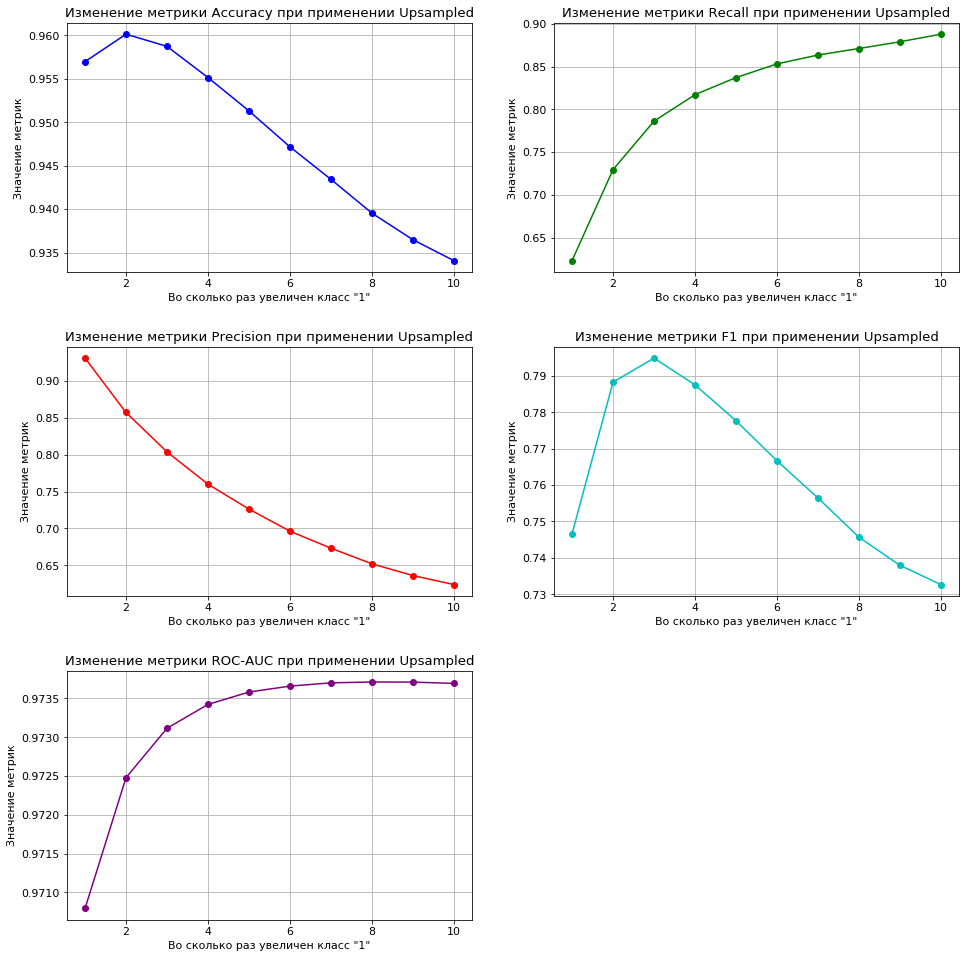

In [34]:
charts_learning_outcomes(learning_outcomes)

<b>Промежуточный итог:</b>
- Можно заметить, что лучшее значении метрики F-1 получается при увеличении класса в три раза.

In [35]:
df_upsampled_tfidf = sampled(sample, sample_corpus, 3, 'tfidf')

In [36]:
model_upsampled = {}

In [37]:
model_upsampled['linear'] = LogisticRegression(random_state = 42, n_jobs = -1)
model_upsampled['tree'] = DecisionTreeClassifier(random_state = 42)
model_upsampled['forest'] = RandomForestClassifier(random_state = 42, n_jobs = -1)

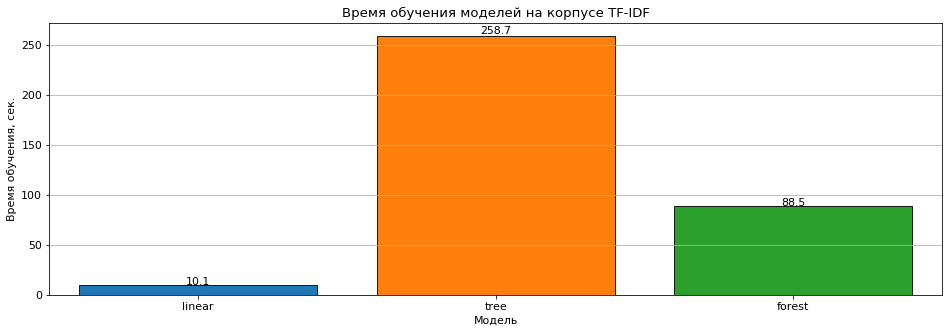

In [38]:
time_fit_upsampled = fit_models(model_upsampled, df_upsampled_tfidf['tfidf_train'], df_upsampled_tfidf['target_train'], 'TF-IDF')

In [39]:
metrics_upsampled = score_metrics(model_upsampled, df_upsampled_tfidf, df_upsampled_tfidf, 'tfidf')

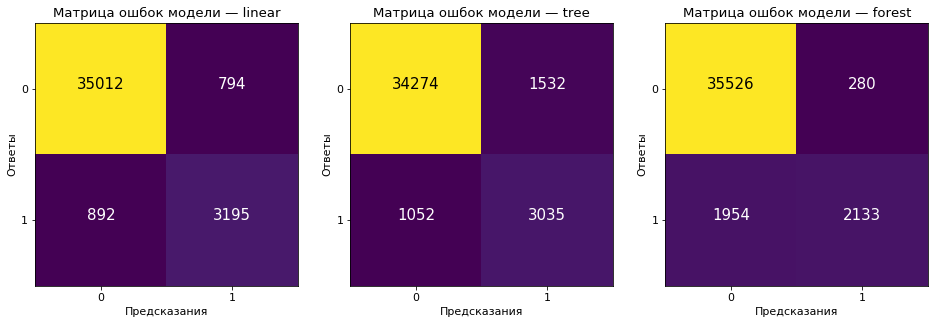

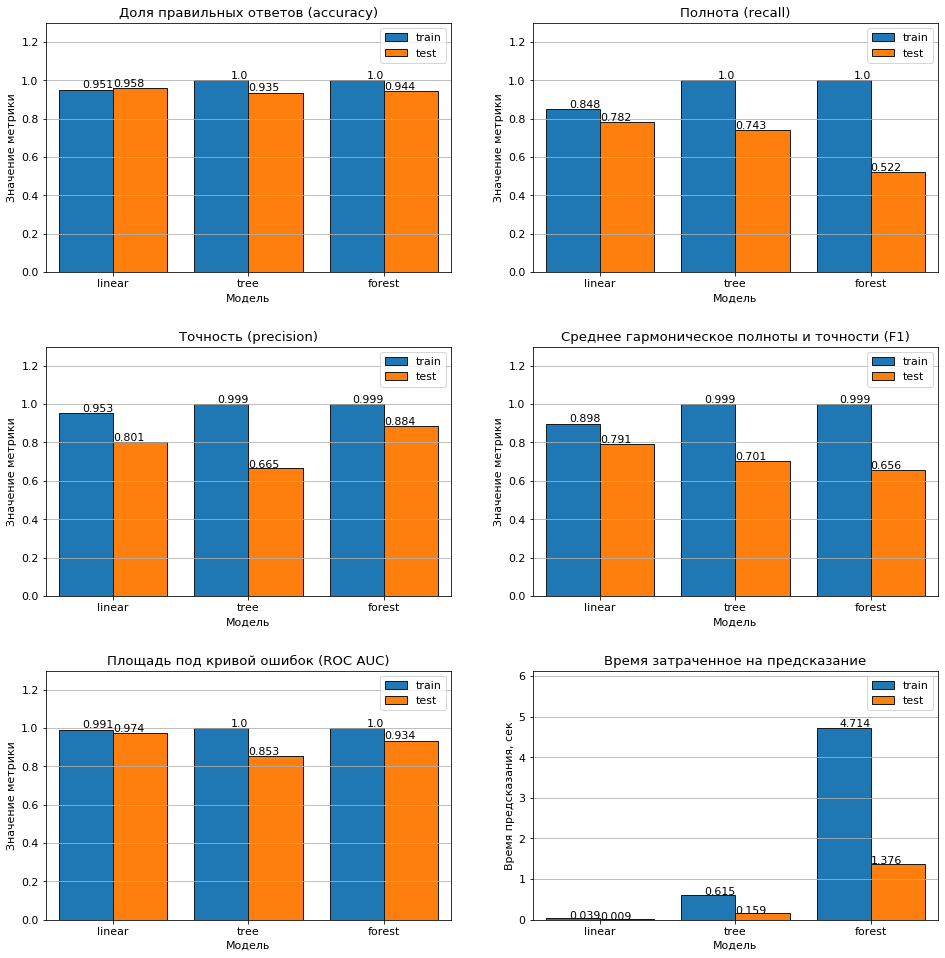

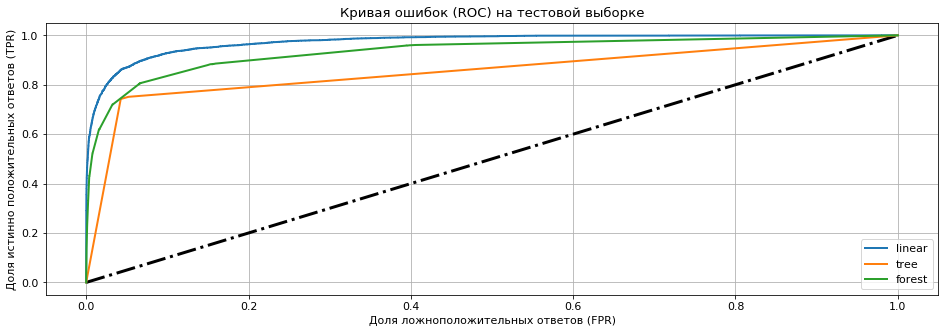

In [40]:
bar_metrics(metrics_upsampled, ['accuracy', 'recall', 'precision', 'f1', 'roc_auc', 'prediction_time'])


<b>Промежуточные выводы:</b>
- Увеличение класса не особо сильно повлияло на качество предсказания RF и DT. В то время как на логистическую регрессию оказало положительное влияение (качество выросло).

In [41]:
def draw_selecting_threshold(models, features, target, metrics):
    
    def list_metrics_threshold(models):
        metrics_threshold = {}
        for model in models:
            pred = models[model].predict_proba(features)
            probabilities = pred[:, 1]
            thresholds = np.arange(0, 1.01, 0.01)
            precision = []
            recall = []
            f1 = []
            roc_auc = []
            accuracy = []
            for threshold in thresholds:
                predicted_bool = probabilities  > threshold
                precision.append(precision_score(target, predicted_bool))
                recall.append(recall_score(target, predicted_bool))
                f1.append(f1_score(target, predicted_bool))
                roc_auc.append(roc_auc_score(target, predicted_bool))
                accuracy.append(accuracy_score(target, predicted_bool))
            data = {'threshold': thresholds, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc, 'accuracy': accuracy}
            df = pd.DataFrame(data)
            metrics_threshold[model] = df.set_index('threshold')
        return metrics_threshold

    def draw_chart_threshold(metrics_threshold, metrics):
        plt.gcf().set_size_inches(16, 13)
        plt.rcParams.update({'font.size': 11})
        for metric in metrics:
            plt.subplot(2, 2, (metrics.index(metric)+1))
            for model in metrics_threshold:
                plt.plot(metrics_threshold[model][metric], label = '{}: при {:.2f} - {:.3f}'.format(model,
                                                                                                         metrics_threshold[model][metric][metrics_threshold[model][metric] == metrics_threshold[model][metric].max()].index.tolist()[0],
                                                                                                         metrics_threshold[model][metric].max()))
                plt.grid()
                plt.legend()
            plt.title('Изменение метрики {} при изменении порога классификации'.format(metric))
            plt.xlabel('Значение порога классификации')
            plt.ylabel('Значение метрики {}'.format(metric))
    
    threshold = list_metrics_threshold(models)
    draw_chart_threshold(threshold, metrics)

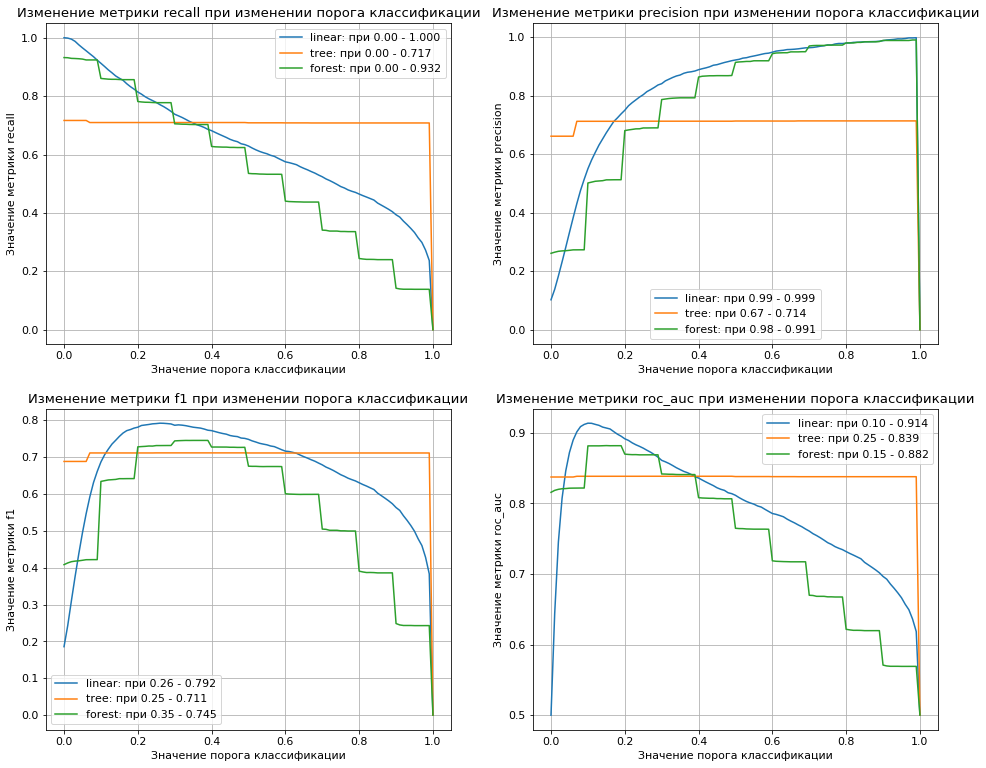

In [42]:
draw_selecting_threshold(models_default_tfidf, sample_corpus['tfidf_test'], sample['target_test'], ['recall', 'precision', 'f1', 'roc_auc'])

<b>"Игра" с порогом классификации улучшает метрики дефолтных моделей.</b>

<b> Ниже модели, обученные на корпусе TF-IDF полученным методом Upsampled.</b>

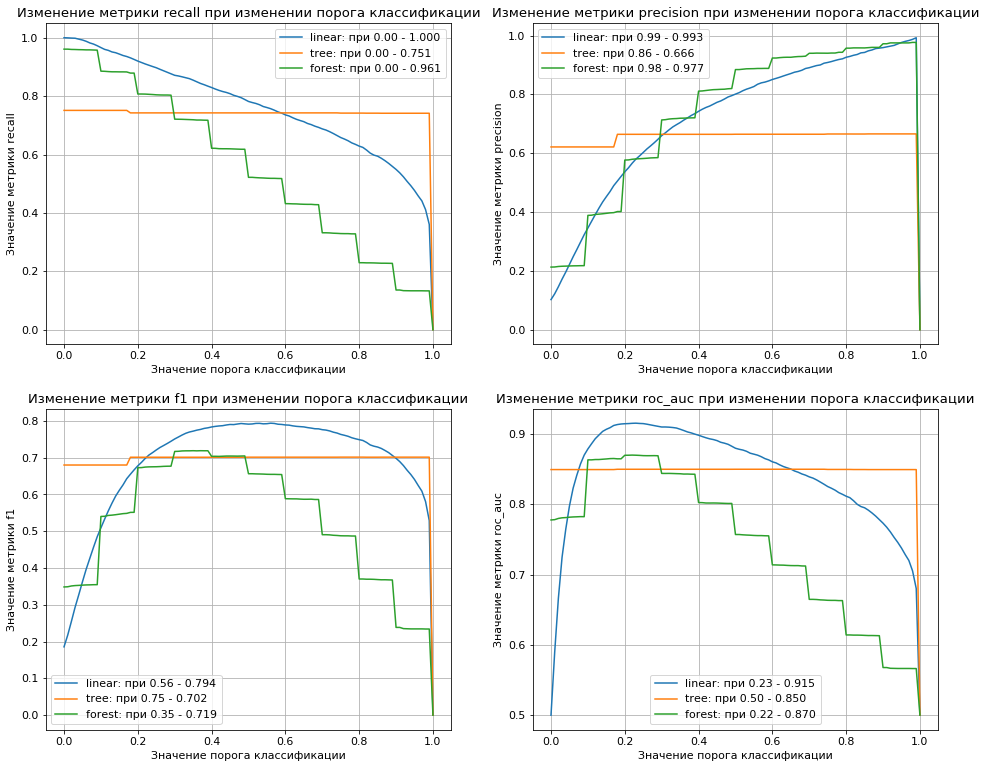

In [43]:
draw_selecting_threshold(model_upsampled, df_upsampled_tfidf['tfidf_test'], df_upsampled_tfidf['target_test'], ['recall', 'precision', 'f1', 'roc_auc'])

<b>Подбор порога классификации не улучшил метрики логистической регрессии. Отсюда делаем вывод, что это не имеет смысла.</b>

In [44]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {'tops':tops, 'bottom':bottom}
    return classes

In [47]:
importance_upsampled = get_most_important_features(tfidf_vectorizer, model_upsampled['linear'], 20)

top_scores_upsampled = [a[0] for a in importance_upsampled[0]['tops']]
top_words_upsampled = [a[1] for a in importance_upsampled[0]['tops']]
bottom_scores_upsampled = [a[0] for a in importance_upsampled[0]['bottom']]
bottom_words_upsampled = [a[1] for a in importance_upsampled[0]['bottom']]

In [48]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, models_default_tfidf['linear'], 20)

top_scores_tfidf = [a[0] for a in importance_tfidf[0]['tops']]
top_words_tfidf = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores_tfidf = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words_tfidf = [a[1] for a in importance_tfidf[0]['bottom']]

In [49]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, title):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    plt.gcf().set_size_inches(16, 8)
    plt.rcParams.update({'font.size': 11}) 

    plt.subplot(1, 2, 1)
    plt.barh(y_pos, bottom_scores, ec = 'k', color = 'lightgreen')
    plt.title('Позитивные слова')
    plt.yticks(y_pos, bottom_words)
    plt.xlabel('Важность')
    plt.grid(axis = 'y')
    
    plt.subplot(1, 2, 2)
    plt.barh(y_pos, top_scores, ec = 'k', color = 'coral')
    plt.title('Токсичные слова')
    plt.yticks(y_pos, top_words)
    plt.xlabel('Важность')
    
    plt.grid(axis = 'y')
    plt.suptitle(title)

<b>LogisticRegression на TF-IDF.</b>

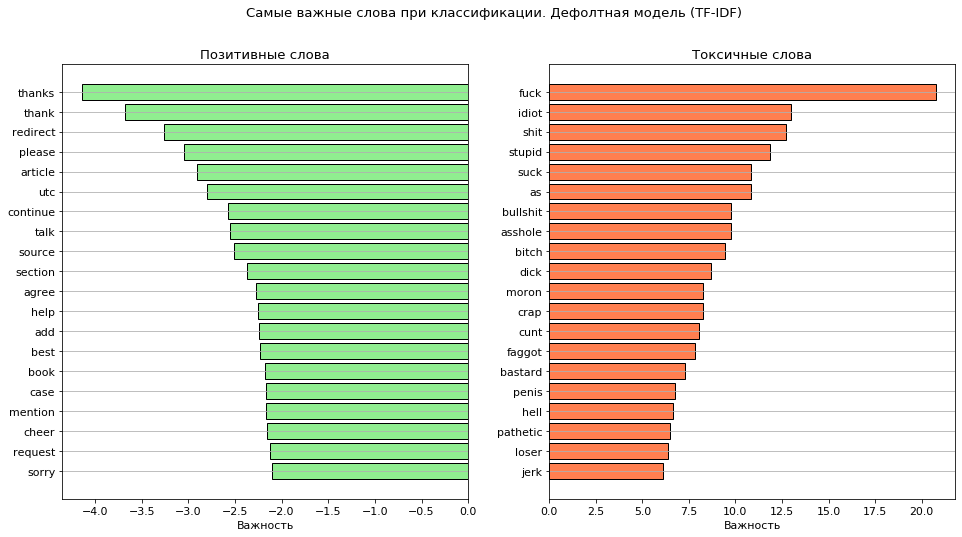

In [50]:
plot_important_words(top_scores_tfidf, top_words_tfidf, bottom_scores_tfidf, bottom_words_tfidf, 'Самые важные слова при классификации. Дефолтная модель (TF-IDF)')

<b>LogisticRegression на TF-IDF методом upsampled.</b>

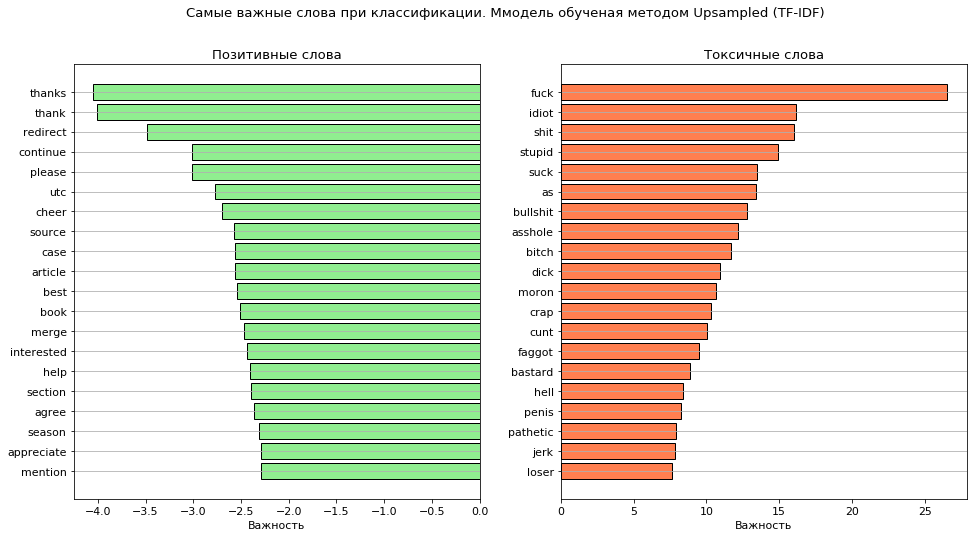

In [51]:
plot_important_words(top_scores_upsampled, top_words_upsampled, bottom_scores_upsampled, bottom_words_upsampled, 'Самые важные слова при классификации. Ммодель обученая методом Upsampled (TF-IDF)')

- Первое, что бросается в глаза это неверно отобранные слова thank и thanks. Можно сделать вывод о том, что лемматизация работает не идеально;
- Модели до балансировки классов и после имеют схожий набор слов, но у них разная значимость;
- Возможно более качественный отбор исходного текста помог бы увеличить точность(но это не точно:) ).

<b>По всей работае можно сделать выводы о том, что обученные модели классификации показывают хорошее значени метрики F1. Так же нам очень помогла балансировка классов.</b>